In [92]:
from __future__ import print_function, division
import cv2 as cv2
import os
import torch
import torchvision
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Type, Dict, Any
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import time
from tqdm import tqdm
import os.path
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
import os
from threading import Thread
from queue import Empty, Queue
import threading
from sklearn.utils import shuffle
import random

In [93]:
torch.manual_seed(378) # обнулили генератор рандома у торча
np.random.seed(378)# обнулили генератор рандома у нампая
torch.backends.cudnn.deterministic = True # ждем одинаковый результат у GPU и CPU Для одинаковых данны переданных торчу
torch.backends.cudnn.benchmark = False # вроде аналогично строчке выше
ia.seed(1)

In [94]:
torch.cuda.device_count()
device1 = torch . device ( "cuda:0" if torch . cuda . is_available () else "cpu" )
print(device1)
device2 = torch.device('cpu')

cuda:0


In [95]:
def start_train(model): # запускаем обучение всех слоев
    for param in model.parameters(): 
        param.requires_grad = True
def draw_circle(image, landmarks): # дорисовываем окружность на изображении и возвращаем обратно
    imageWithCircle = cv2.circle(image, (int(landmarks[0][0]),int(landmarks[0][1]) ),int(landmarks[0][2]), (255, 0 , 0),  10)
    return imageWithCircle


def show_landmarks(image, landmarks): # конкретно эта функция, скорее всего не понадобится
    """Show image with landmarks"""
    plt.imshow(draw_circle(image,landmarks) )
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r') # начало координат не совпадает , надо учесть
    # для картинки надо, для нейросетки не нужно, начало координат должно совпасть
    # в numpy 0-левая координата - у, первая - иксы(столбцы)
    # порисовать диск солнце порисовать кружочки через opencv(там с координатами тоже не все гладко, надо внимательно смотреть)
    # размеры реальных снимков 1920х1920 а не 1200х1200, надо как-то или к долям 1 или сразу в 1920х1920 формат
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def calculate_loss(model_result : torch.tensor, 
                   data_target  : torch.tensor,
                   loss_function: torch.nn.Module = torch.nn.MSELoss()): #reduction = None
    lossXY =  (loss_function(model_result[:,:2], data_target[:,:2]))**(0.5) # тут из батчей получаю, править
    lossR =  loss_function(model_result[:,2], data_target[:,2]) # потом корень извлечь
    #return {'lossXY': lossXY.item(),'lossR': lossR.item() }
    return { lossXY.item(), lossR.item() }


In [96]:
resnet152 = models.resnet152(pretrained=True, progress=False)
for p in resnet152.parameters():
    print(p.device)
    break
for param in resnet152.parameters(): # запрещаем обучаться resnet 152
    param.requires_grad = False
resnet152.fc = torch.nn.Sequential(nn.Linear(in_features=2048, out_features=256, bias=True),
                            nn.ReLU(),
                            nn.Linear(in_features=256, out_features=128, bias=True),
                            nn.ReLU(), # SeLU или GeLU возможно подойдут лучше, надо поиграться
                            nn.Linear(in_features=128, out_features=3, bias=True)) # мой франкенштейн для регрессии, который подцепили к resnet сфот
_ = resnet152.to(device1)

cpu


In [98]:
alexnet = models.alexnet(pretrained=True, progress=False)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# упомянуть челиков из imgaug
## тут агментация данных дальше

In [60]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),# horizontally flip 20% of the images flipud
    iaa.Flipud(0.5),# vertically flip 20% of the images flipud добавить на 180 градусов поворот
    iaa.GaussianBlur(sigma=(0, 5)), # blur images with a sigma of 0 to 0.5
    #iaa.Invert(0.1) # пока уберем
    iaa.Affine(rotate=(-180,180))# поворот на 180 через афииные преобразования
])
# kps = KeypointsOnImage([
#     Keypoint(x=landmarks[:,0], y=landmarks[:,1])
# ], shape=(1920,1920,3))

In [61]:
def find_files(dataset_dir):
    image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir)]
    return image_filenames


class thread_killer(object):    
    """Boolean object for signaling a worker thread to terminate"""
    def __init__(self):
        self.to_kill = False

    def __call__(self):
        return self.to_kill

    def set_tokill(self, tokill):
        self.to_kill = tokill


def threaded_batches_feeder(tokill, batches_queue, dataset_generator):
    """
    Threaded worker for pre-processing input data.
    tokill is a thread_killer object that indicates whether a thread should be terminated
    dataset_generator is the training/validation dataset generator
    batches_queue is a limited size thread-safe Queue instance.
    """
    while tokill() == False:
        for _, sample_batch in enumerate(dataset_generator): #__getitem() will be called here
            #We fill the queue with new fetched batch until we reach the max size.
#             batches_queue.put(((sample['image'], sample['landmarks'])), block=True)
            batches_queue.put(torch.Tensor(sample_batch), block=True)
            if tokill() == True:
                return


def threaded_cuda_batches(tokill,cuda_batches_queue,batches_queue):
    
    """
    Thread worker for transferring pytorch tensors into GPU. 
    batches_queue is the queue that fetches numpy cpu tensors.
    cuda_batches_queue receives numpy cpu tensors and transfers them to GPU space.
    """
    while tokill() == False:
#         (sample['image'], sample['landmarks']) = batches_queue.get(block=True)
        sample_batch = batches_queue.get(block=True)
        sample_batch = Variable(sample_batch).to(device)
#         sample['image'] = Variable(sample['image']).cuda()
#         sample['landmarks'] = Variable(sample['landmarks']).cuda()
        
        
#         cuda_batches_queue.put(((sample['image'], sample['landmarks'])), block=True)
        cuda_batches_queue.put(sample_batch, block=True)
        if tokill() == True:
            return


class threadsafe_iter:
    """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.it)

def get_objects_i(objects_count):
    """Cyclic generator of paths indices
    """
    current_objects_id = 0
    while True:
        yield current_objects_id
        current_objects_id  = (current_objects_id + 1) % objects_count

In [62]:

# for item, url in enumerate(urls):
#     name = "Поток %s" % (item+1)
#     thread = DownloadThread(url, name)
#     thread.start()
 

In [63]:
class SunLandmarksDataset(Dataset):
    """Sun Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None, batch_size = 10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file,delimiter=',') # чертов разделитель 
        self.root_dir = root_dir
        self.transform = transform
        self.batch_size = batch_size

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #landmarks_frame.iloc[n, 0]
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0]) #self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(1, 3)
        
        kps = KeypointsOnImage([
                Keypoint(x=landmarks[0,0]*1920, y=landmarks[0,1]*1920) # домножил, тк нормировал
        ], shape=image.shape)
        image_aug, landmarks_after =seq(image = image, keypoints = kps) # тут применяю аугментацию к фотке и целевой переменной
        landmarks[0,0] = landmarks_after.keypoints[0].x/1920 # обратно отнормировал 
        landmarks[0,1] = landmarks_after.keypoints[0].y/1920
        image = image_aug
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample


    def shuffle(self):
        self.landmarks_frame = shuffle(self.landmarks_frame)
    
    def __iter__(self): # выполняется постоянно фоном в зависимости от размера батча
        while True:
            with self.lock:
                if (self.init_count == 0):
                    self.shuffle()
#                     self.imgs, self.landmarks = [], []
                    self.imgs = []
                    self.init_count = 1
            
            for obj_id in self.objects_id_generator:
                image_set = []
                for i in range(6):
                    img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
                    img = io.imread(img_name)
                    image_set.append(img)
                image_set = np.concatenate(image_set, axis=-1)
                landmarks = self.landmarks_frame.iloc[obj_id, 6:]
                landmarks = landmarks.to_numpy(int)
                landmarks = landmarks.reshape(-1, 4)
                
                
                image = image_set[landmarks[0, 2]: landmarks[0, 3],     
                                  landmarks[0, 0]: landmarks[0, 1], :] # тут скорее всего аугментировать и не понятно какие фотки берутся
                        #sample = {'image': image, 'landmarks': landmarks}


                #image = image.transpose((2, 0, 1))
                #image = transform.resize(image, (18, 280, 280))
#                 image = torch.from_numpy(image)
#                 landmarks = torch.from_numpy(landmarks)
#                 return {'image': image, 'landmarks': landmarks}
                
                
#                 sample = {'image': image_set, 'landmarks': landmarks}
                
                # Concurrent access by multiple threads to the lists below
                with self.yield_lock:
                    if (len(self.imgs)) < self.batch_size:
                        self.imgs.append(image)
#                         self.landmarks.append(landmarks)
                    if len(self.imgs) % self.batch_size == 0:
                        imgs_f32 = np.float32(self.imgs)
#                         landmarks_f32 = np.float32(self.landmarks)
#                         yield imgs_f32, landmarks_f32
                        yield imgs_f32
                        self.imgs, self.landmarks = [], []
                        #self.imgs = []
            # At the end of an epoch we re-init data-structures
            with self.lock:
                self.landmarks_frame = shuffle(self.landmarks_frame)
                self.init_count = 0


In [65]:
# class ToTensor(object):
#     """Convert ndarrays in sample to Tensors."""

#     def __call__(self, sample):
#         image, landmarks = sample['image'], sample['landmarks']

#         # swap color axis because
#         # numpy image: H x W x C
#         # torch image: C X H X W
#         image = image.transpose((2, 0, 1))
#         image = image.copy() # какая-та жопа была с шагом, текст ошибки прямо советовал просто копировать
#         return {'image': torch.from_numpy(image),
#                 'landmarks': torch.from_numpy(landmarks)}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image = sample
        return torch.from_numpy(image)

In [66]:
batch_size = 10
sun_dataset_train = SunLandmarksDataset(csv_file='sun_disk_pos_database01train.csv',
                                           root_dir='/app/images',
                                           transform=transforms.Compose([
                                               ToTensor()
                                           ]), batch_size=batch_size)
sun_dataset_test = SunLandmarksDataset(csv_file='sun_disk_pos_database01test.csv',
                                           root_dir='/app/images',
                                           transform=transforms.Compose([
                                               ToTensor()
                                           ]), batch_size=batch_size)

In [83]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.MSELoss(), # loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss() 
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                lr_scheduler_class: Any = torch.optim.lr_scheduler.CosineAnnealingLR,
                initial_lr = float,
                lr_scheduler_params: Dict = {},
                batch_size = int,
                max_epochs = 100,
                early_stopping_patience = 20):

    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)

#     train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size,drop_last=False)
#     val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,drop_last=False)
    
    best_val_loss = None
    best_epoch = None
    loss_value = []
    loss_valueXY = []
    loss_valueR = []
    
    batches_queue_length =16

    train_batches_queue = Queue(maxsize=batches_queue_length)
    train_cuda_batches_queue = Queue(maxsize=8)
    train_thread_killer = thread_killer()
    train_thread_killer.set_tokill(False)
    preprocess_workers = 16

    for _ in range(preprocess_workers):
        thr = Thread(target=threaded_batches_feeder, args=(train_thread_killer, train_batches_queue, train_dataset))
        thr.start()

    train_cuda_transfers_thread_killer = thread_killer()
    train_cuda_transfers_thread_killer.set_tokill(False)
    train_cudathread = Thread(target=threaded_cuda_batches, args=(train_cuda_transfers_thread_killer, train_cuda_batches_queue,
                                                                  train_batches_queue))
    train_cudathread.start()
    
#     batches_queue_length =16 потом для вал датасета переимнеовать

#     train_batches_queue = Queue(maxsize=batches_queue_length)
#     train_cuda_batches_queue = Queue(maxsize=8)
#     train_thread_killer = thread_killer()
#     train_thread_killer.set_tokill(False)
#     preprocess_workers = 16

#     for _ in range(preprocess_workers):
#         thr = Thread(target=threaded_batches_feeder, args=(train_thread_killer, train_batches_queue, dataset))
#         thr.start()

#     train_cuda_transfers_thread_killer = thread_killer()
#     train_cuda_transfers_thread_killer.set_tokill(False)
#     train_cudathread = Thread(target=threaded_cuda_batches, args=(train_cuda_transfers_thread_killer, train_cuda_batches_queue,
#                                                                   train_batches_queue))
#     train_cudathread.start()
    
    for epoch in range(max_epochs):
        
        print(f'Epoch {epoch}')
        train_single_epoch(model, optimizer, loss_function, train_cuda_batches_queue) # передать х
        val_metrics, lossXY, lossR = validate_single_epoch(model, loss_function, val_cuda_batches_queue)
        loss_value = np.append(loss_value,val_metrics) # добавляю в массив значение функци потерь
        loss_valueXY = np.append(loss_valueXY,lossXY)
        loss_valueR = np.append(loss_valueR,lossR)
        np.save('loss_value+aug',loss_value )
        np.save('loss_valueXY+aug',loss_valueXY )
        np.save('loss_valueR+aug',loss_valueR )
        print(f'Validation metrics: \n{val_metrics}')
        


        lr_scheduler.step() #lr_scheduler.step(val_metrics['loss'])


        
        if best_val_loss is None or best_val_loss > val_metrics:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics
            best_epoch = epoch
            torch.save(model, 'saved_models/best_model+aug.pth') 

        
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return
        
        
    val_thread_killer.set_tokill(True) # убиваю потокои, так же убить валидационные
    val_cuda_transfers_thread_killer.set_tokill(True)
    for _ in range(preprocess_workers):
        try:
            # Enforcing thread shutdown
            val_batches_queue.get(block=True, timeout=1)
            val_cuda_batches_queue.get(block=True, timeout=1)
        except Empty:
            pass

In [84]:
def validate_single_epoch(model: torch.nn.Module,
                        loss_function: torch.nn.Module, 
                        #data_loader: torch.utils.data.DataLoader
                        val_dataset: torch.utils.data.Dataset):
    



    test_loss = 0
    correct = 0
    lossXY = 0
    lossR = 0
    loss1 = 0
    loss2 = 0
    model.eval()
    for batch_idx , data in enumerate(train_loader):
        data_image = data['image'].float()
        data_image = Variable(data_image)
        data_image = data_image.to(device1) # отправили на GPU
        #target = torch.squeeze(data['landmarks'].float())
        target = data['landmarks'].float().view(-1,3)
        target = Variable(target) # трансформировали переменные для pytorch , volatile=True
        target = target.to(device1)
        data_out = model(data_image)
        loss = loss_function(data_out, target) # посчитали на изображении
        test_loss += loss.item() # прибавили
        loss1 , loss2 = calculate_loss(data_out, target) # тут считаю свои метрики
        lossXY +=loss1
        lossR  +=loss2
        
    test_loss /= len(data_loader.dataset) 
    lossXY    /= len(data_loader.dataset) # корень извлечь и поправить функцию расчета
    lossR     /= len(data_loader.dataset)  # корень извлечь
    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #      test_loss, correct, len(data_loader.dataset),
    #      100. * correct / len(data_loader.dataset)))
    #return {'loss':test_loss,'lossXY':lossXY,'lossR':lossR, } #, correct
    #return {'loss':test_loss,'lossXY':lossXY,'lossR':lossR}
    return {test_loss,lossXY,lossR}

In [89]:
def train_single_epoch(model: torch.nn.Module,
                    optimizer: torch.optim.Optimizer, 
                    loss_function: torch.nn.Module,
                    cuda_batches_queue: Queue):
                    #data_loader: torch.utils.data.DataLoader):

    model.train()
#     for _ in range(preprocess_workers):
#         thr = Thread(target=threaded_batches_feeder, args=(train_thread_killer, train_batches_queue, dataset))
#         thr.start()
#     train_batches_queue = Queue(maxsize=16)
#     train_cuda_batches_queue = Queue(maxsize=8)
#     train_thread_killer = thread_killer()
#     train_thread_killer.set_tokill(False)
#     preprocess_workers = 16
    
#     train_cudathread = Thread(target=threaded_cuda_batches, args=(train_cuda_transfers_thread_killer, train_cuda_batches_queue,
#                                                               train_batches_queue))

#     train_cudathread.start()
    #data_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size,drop_last=False)
   # pbar = tqdm(total=len(data_loader))
    
    
#     for i in range(smth):
#         x = train_cuda_batches_queue.get(block=True)
#         # дальше тупо обучаю
        
    for batch_idx in range(10):
        data_image = cuda_batches_queue.get
        print(data_image)
    for batch_idx , data in enumerate(data_loader): 
        data_image = data['image'].float() # считали только изображение в формате float, чтобы накормить модель
        data_image = Variable(data_image)
        data_image = data_image.to(device1) # отправили на GPU
        #target = torch.squeeze(data['landmarks'].float())
        target = data['landmarks'].float().view(-1,3)
        target = Variable(target) # трансформировали переменные для pytorch , volatile=True
        target = target.to(device1)
        optimizer.zero_grad() # обнулили\перезапустии градиенты для обратного распространения
        data_out = model(data_image) # применили модель к данным
        loss = loss_function(data_out, target) # применили фуннкцию потерь
        loss.backward() # пошли по графу нейросетки обратно
        optimizer.step()# выполняем наш градиентный спуск по вычисленным шагам в предыдущей строчке
        pbar.update(1)
        pbar.set_postfix({'loss': loss.item()})
        
        
    return {'loss': loss.item()}

In [90]:
# if os.path.exists('saved_models/best_model-aug.pth') :
#     resnet152load = torch.load('saved_models/best_model-aug.pth')
#     train_model(resnet152load, 
#             train_dataset = sun_dataset_train, 
#             val_dataset =  sun_dataset_test,   
#             loss_function = torch.nn.MSELoss(), 
#             lr_scheduler_class = torch.optim.lr_scheduler.CosineAnnealingLR,
#             lr_scheduler_params = {'T_max': 100, 'last_epoch': -1, 'eta_min': 0.0001},
#             initial_lr=0.0001,
#             batch_size = 10)
# else:
#     train_model(resnet152, 
#             train_dataset = sun_dataset_train, 
#             val_dataset =  sun_dataset_test,  
#             loss_function = torch.nn.MSELoss(), 
#             lr_scheduler_class = torch.optim.lr_scheduler.CosineAnnealingLR,
#             lr_scheduler_params = {'T_max': 100, 'last_epoch': -1, 'eta_min': 0.0001},
#             initial_lr=0.0001,
#             batch_size = 10)

In [91]:
    train_model(resnet152, 
            train_dataset = sun_dataset_train, 
            val_dataset =  sun_dataset_test,  
            loss_function = torch.nn.MSELoss(), 
            lr_scheduler_class = torch.optim.lr_scheduler.CosineAnnealingLR,
            lr_scheduler_params = {'T_max': 100, 'last_epoch': -1, 'eta_min': 1e-7},
            initial_lr=1e-4,
            batch_size = 10)

Epoch 0
<bound method Queue.get of <queue.Queue object at 0x7f6db2ec2ba8>>
<bound method Queue.get of <queue.Queue object at 0x7f6db2ec2ba8>>
<bound method Queue.get of <queue.Queue object at 0x7f6db2ec2ba8>>
<bound method Queue.get of <queue.Queue object at 0x7f6db2ec2ba8>>
<bound method Queue.get of <queue.Queue object at 0x7f6db2ec2ba8>>
<bound method Queue.get of <queue.Queue object at 0x7f6db2ec2ba8>>
<bound method Queue.get of <queue.Queue object at 0x7f6db2ec2ba8>>
<bound method Queue.get of <queue.Queue object at 0x7f6db2ec2ba8>>
<bound method Queue.get of <queue.Queue object at 0x7f6db2ec2ba8>>
<bound method Queue.get of <queue.Queue object at 0x7f6db2ec2ba8>>


Exception in thread Thread-56:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-61-0f9513104300>", line 26, in threaded_batches_feeder
    for _, sample_batch in enumerate(dataset_generator): #__getitem() will be called here
  File "<ipython-input-63-5f35b6e7c731>", line 49, in __iter__
    with self.lock:
AttributeError: 'SunLandmarksDataset' object has no attribute 'lock'

Exception in thread Thread-57:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-61-0f9513104300>", line 26, in threaded_batches_feeder
    for _, sample_batch in enumerate(dataset_generator): #__g

NameError: name 'data_loader' is not defined

# функция применения модели к данным

In [ ]:
def use_model(image):
    #model = torch.load(path) можно допилить, что по путю модель берем
    image = np.transpose(image,(2, 0, 1)) # меняем каналы для тензора
    image = image[np.newaxis, ...] # новая ось, потому что модели нужен 4д кун
    image = torch.from_numpy(image) # в тензор
    image = image.float() # ебля с типами данных
    image = image.to(device1)  # отправили на видеокарту
    #model = torch.load('saved_models/Reserv/best_model-aug-Copy1.pth') # грузанули модель 'saved_models/best_model-aug2.pth'
    model = torch.load('saved_models/best_model+aug.pth')
    model = model.to(device1)  # отправили на видеокарту
    data_out =(model(image))*1920 # применили модель к изображению
    data_out = data_out.to(device2) # вернули на процессор
    data_out = data_out[0].int().detach().numpy() # ебля с данными и типами
    image = image.int() # ебля с данными и типами
    image = image.to(device2) # вернули на процессор
    image = image.numpy() # ебля с данными и типами
    image = image[0,:,:] # ебля с данными, срез до 3д массива
    image = np.transpose(image,(1,2,0))# меняем каналы для нампай массива
    image = image.copy() # без этого в рисовании круга проблема
    center_coordinates = (data_out[0], data_out[1]) # данные для кружочка и рисование 
    radius = data_out[2]
    color = (255, 0 , 0)
    thickness  = 10 
    image = cv2.circle(image, center_coordinates ,radius, color,  thickness )
    return image



In [ ]:
image = plt.imread('images/img-2015-12-22T06-01-53devID1.jpg')
image = use_model(image)
plt.imshow(image)

# рисуем графики лоссов

In [32]:
a = np.load('loss_value+aug.npy')
b = np.load('loss_valueR+aug.npy')
c = np.load('loss_valueXY+aug.npy')
#plt.show(a.all)
a

array([0.00335064, 0.0220869 , 0.02158827, 0.02177216, 0.0207075 ,
       0.00283286, 0.02066971, 0.0195817 , 0.01939792, 0.00242878,
       0.0183738 , 0.01800201, 0.01811014, 0.017979  , 0.0022516 ,
       0.01984217, 0.00216761, 0.01902334, 0.01735288, 0.01739951,
       0.01837203, 0.0170073 , 0.01725206, 0.01728235, 0.01726885,
       0.00243687, 0.01655579, 0.01717606, 0.01641282])

In [33]:
z0 =a.shape[0]
z1 =b.shape[0]
z2 =c.shape[0]

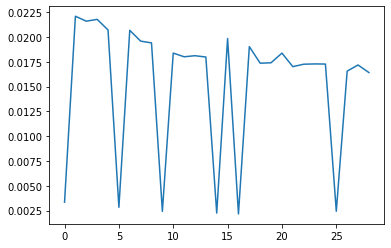

In [34]:
x = np.arange(z0)
y = a
y1 = b
y2 = c
fig = plt.figure()
fig.patch.set_facecolor('white') 
plt.plot(x, y) # y1

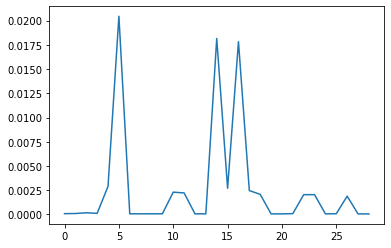

In [35]:
x = np.arange(z1)
y = b
fig = plt.figure()
plt.plot(x, y)

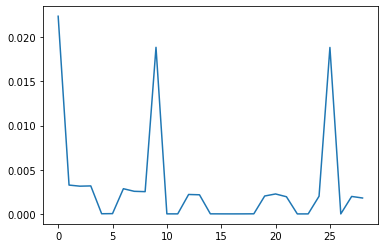

In [37]:
x = np.arange(z2)
y = c
fig = plt.figure()
plt.plot(x, y)
fig.patch.set_facecolor('white') 